In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["GEOMSTATS_BACKEND"] = 'jax'

import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

from score_sde.utils import GlobalRNG

g_rng = GlobalRNG()

## Define an SDE class

In [2]:
from score_sde.sde import SDE, VPSDE, RSDE, ProbabilityFlowODE

INFO:root:Using jax backend


## Define rollout sampler for an SDE

In [3]:
from score_sde.sampling import get_pc_sampler

In [4]:
def plot_2dsde(x_hist):
    fig, axes = plt.subplots(1,3, sharey=False, figsize=(9,3))

    axes[0].set_aspect('equal', share=False)
    n = 4
    for i in range(n):
        i = int(i * x_hist.shape[1] / n)
        sns.kdeplot(x_hist[:,i,0], x_hist[:,i,1], ax=axes[0])
    sns.kdeplot(x_hist[:,-1,0], x_hist[:,-1,1], ax=axes[0])

    axes[1].plot(x_hist.mean(axis=0)[..., 0], label='x')
    axes[1].plot(x_hist.mean(axis=0)[..., 1], label='y')
    axes[1].legend()

    axes[2].plot(x_hist.std(axis=0)[..., 0], label='x')
    axes[2].plot(x_hist.std(axis=0)[..., 1], label='y')
    axes[2].legend()
    
    axes[0].set_title("KDE estimate")
    axes[1].set_title("Mean")
    axes[2].set_title("Std")

    plt.tight_layout()

    return fig, axes

2022-01-18 15:22:22.322665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


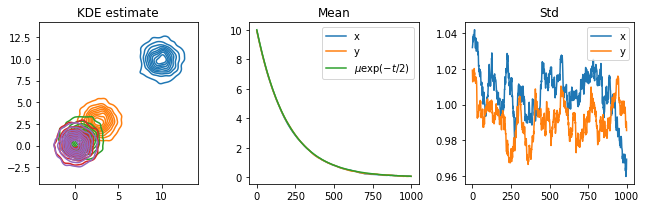

In [5]:
N=1000
forward_sde = VPSDE(10, beta_0=1, beta_f=1)
sampler = get_pc_sampler(forward_sde, N=N, predictor='EulerMaruyamaPredictor')

mean, var = 10, 1
from score_sde.datasets import GaussianMixture
dataset = GaussianMixture((2000,), next(g_rng), means=[jnp.array([mean,mean])], stds=[jnp.array([var,var])], weights=[1.0])
dataset.means.shape
x_init = next(dataset)

x_sample, x_hist = sampler(jax.random.PRNGKey(0), x_init)

fig, axes = plot_2dsde(x_hist.swapaxes(0, 1))
t_ = jnp.linspace(forward_sde.t0, forward_sde.tf,num=N, endpoint=True)
axes[1].plot(mean * jnp.exp(-0.5 * t_), label='$\mu \exp(-t/2)$')
axes[1].legend()
axes[2].legend()

# plt.scatter(x_init[..., 0], x_init[..., 1])

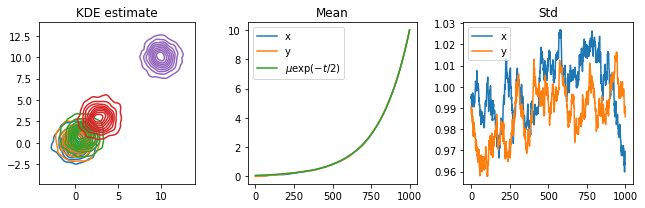

In [6]:
# This score function is ONLY accurate for beta(t) = 1
def score_fn(x, t):
    return -(x - mean * jnp.exp(-t[..., None]/2))

reverse_sde = RSDE(forward_sde, score_fn)
reverse_sampler = get_pc_sampler(reverse_sde, N=N, predictor='EulerMaruyamaPredictor')

x_init = reverse_sde.sde.sample_limiting_distribution(jax.random.PRNGKey(0), (2000,2))

x_sample, x_hist = reverse_sampler(jax.random.PRNGKey(0), x_init)

fig, axes = plot_2dsde(x_hist.swapaxes(0, 1))
t_ = jnp.linspace(reverse_sde.t0, reverse_sde.tf,num=N, endpoint=True)
axes[1].plot(mean * jnp.exp(-0.5 * t_), label='$\mu \exp(-t/2)$')
axes[1].legend()
axes[2].legend()


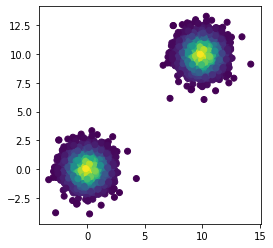

In [7]:
from score_sde.likelihood import get_likelihood_fn

x_init = mean + var * forward_sde.sample_limiting_distribution(jax.random.PRNGKey(0), (2000,2))

likelihood_fn = get_likelihood_fn(forward_sde, score_fn, hutchinson_type='Gaussian', bits_per_dimension=False)
logl, z, N = likelihood_fn(next(g_rng), x_init)

plt.scatter(x_init[..., 0], x_init[..., 1], c = jnp.exp(logl))
plt.scatter(z[..., 0], z[..., 1], c = jnp.exp(forward_sde.limiting_distribution_logp(z)))
plt.gca().set_aspect('equal')

In [39]:
from score_sde.models import AmbientGenerator, Concat
from score_sde.utils import TrainState
from score_sde.losses import get_loss_step_fn, get_dsm_loss_fn
import geomstats as gs
import haiku as hk
import optax

manifold = gs.geometry.euclidean.Euclidean(2)

def score_model(x, t):
    score = AmbientGenerator(dict(
        _target_ = "score_sde.models.Concat",
        hidden_shapes = [512,512,512], 
        act='sin'
    ), 2, manifold)
    return score(x, t)

score_model = hk.transform_with_state(score_model)

x = next(dataset)
params, state = score_model.init(rng=next(g_rng), x=x, t=0)

warmup_steps = 100
steps = 900
schedule_fn = optax.join_schedules([
        optax.linear_schedule(
            init_value= 0.0,
            end_value= 1.0,
            transition_steps = warmup_steps
        ),
        optax.cosine_decay_schedule(
            init_value= 1.0,
            decay_steps=steps - warmup_steps,
            alpha= 0.0
        )
    ],
  boundaries=[warmup_steps]
)

optimiser = optax.chain(
    optax.adam(learning_rate=0.0002, b1=0.9,b2=0.999, eps=1e-8), optax.scale_by_schedule(schedule_fn)
)
opt_state = optimiser.init(params)

next_rng = next(g_rng)
train_state = TrainState(
    opt_state=opt_state,
    model_state=state,
    step=0,
    params=params,
    ema_rate=0.999,
    params_ema=params,
    rng=next_rng,
)

loss_fn = get_dsm_loss_fn(forward_sde, score_model, True)
train_step_fn = get_loss_step_fn(loss_fn, optimiser, True)

train_step_fn = jax.jit(train_step_fn)

rng = next(g_rng)
for i in range(steps):
    batch = {"data": next(dataset)}
    rng, next_rng = jax.random.split(rng)
    (rng, train_state), loss = train_step_fn((next_rng, train_state), batch)
    if i % 50 == 0:
        print(f"{i:4d}: {loss:.3f}")

   0: 16948.900
  50: 1432.930
 100: 19309.613
 150: 3520.042
 200: 1285.385
 250: 2147.738
 300: 7375.318
 350: 2952.952
 400: 3079.518
 450: 42378.270
 500: 5184.593
 550: 30907.486
 600: 497.236
 650: 2311.362
 700: 240.950
 750: 258.338
 800: 2193.887
 850: 39364.867


In [40]:
from score_sde.models import get_score_fn

nn_score_fn = get_score_fn(forward_sde, score_model, train_state.params_ema, train_state.model_state, continuous=True)

In [46]:
x_t = forward_sde.sample_limiting_distribution(next(g_rng), (2000,2)) #next(dataset)
x_0 = jnp.zeros_like(x_t)

forward_sde.marginal_prob(x_t, 10 * jnp.ones(x_t.shape[:-1]))
# forward_sde.marginal_log_prob(x_0, x_t, 10 * jnp.ones(x_t.shape[:-1]))
# forward_sde

(DeviceArray([[-0.00033008,  0.00407723],
              [-0.01223589, -0.00212549],
              [ 0.00140423, -0.00228502],
              ...,
              [-0.00126581,  0.0040356 ],
              [-0.00423139, -0.00640921],
              [ 0.00018401, -0.0076332 ]], dtype=float32),
 DeviceArray([0.9999773, 0.9999773, 0.9999773, ..., 0.9999773, 0.9999773,
              0.9999773], dtype=float32))

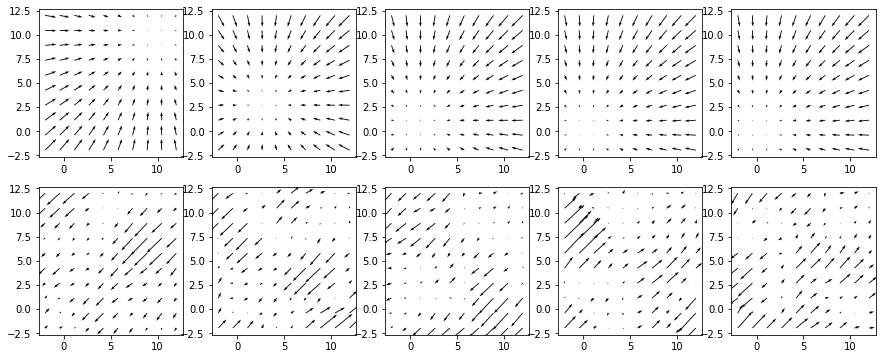

In [42]:
n = 5

fig, axs = plt.subplots(2, n, figsize=(n*3, 2*3))

x = jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-2,12,10), jnp.linspace(-2,12,10)
    ), axis=-1
).reshape((1,-1,2))

for i in range(n):
    t = (i * forward_sde.tf)/(n-1) + 1e-3
    nn_score = nn_score_fn(x, t * jnp.ones(x.shape[:-1]))
    score = score_fn(x, t * jnp.ones(x.shape[:-1]))

    axs[0][i].quiver(x[..., 0], x[..., 1], score[..., 0], score[..., 1])
    axs[1][i].quiver(x[..., 0], x[..., 1], nn_score[..., 0], nn_score[..., 1])

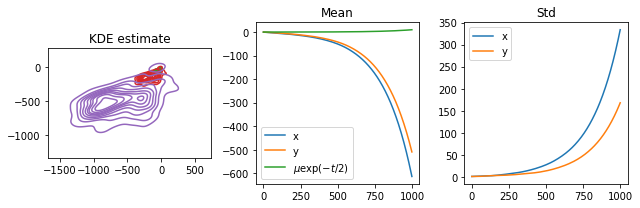

In [17]:
# This score function is ONLY accurate for beta(t) = 1   

reverse_sde = RSDE(forward_sde, jax.jit(nn_score_fn))
reverse_sampler = jax.jit(get_pc_sampler(reverse_sde, N=N, predictor='EulerMaruyamaPredictor'))

x_init = reverse_sde.sde.sample_limiting_distribution(jax.random.PRNGKey(0), (2000,2))

x_sample, x_hist = reverse_sampler(jax.random.PRNGKey(0), x_init)

fig, axes = plot_2dsde(x_hist.swapaxes(0, 1))
t_ = jnp.linspace(reverse_sde.t0, reverse_sde.tf,num=N, endpoint=True)
axes[1].plot(mean * jnp.exp(-0.5 * t_), label='$\mu \exp(-t/2)$')
axes[1].legend()
axes[2].legend()

In [10]:
import geomstats as gs
from riemannian_score_sde.sde import Brownian

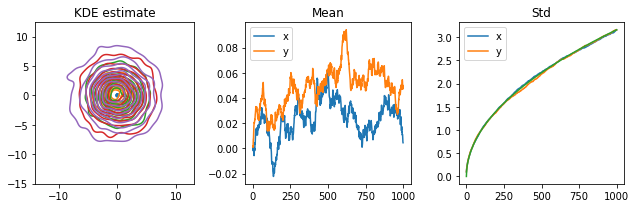

In [17]:
N=1000
forward_sde = Brownian(gs.geometry.euclidean.Euclidean(2), 10, beta_0=1, beta_f=1)
sampler = get_pc_sampler(forward_sde, N=N, predictor='EulerMaruyamaManifoldPredictor')

mean, var = 0, 1
x_init = jnp.zeros((2000,2))# mean + var * jax.random.normal(jax.random.PRNGKey(0), (2000,2))

x_sample, x_hist = sampler(jax.random.PRNGKey(0), x_init)

fig, axes = plot_2dsde(x_hist.swapaxes(0, 1))
t_ = jnp.linspace(forward_sde.t0, forward_sde.tf,num=N, endpoint=True)
axes[2].plot(jnp.sqrt(t_), label='$\sqrt{t}$')
# axes[1].legend()
# axes[2].legend()